In [192]:
from IPython.core.display import HTML
display(HTML("""
<script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click here to toggle on/off the raw code.">
</form>"""))

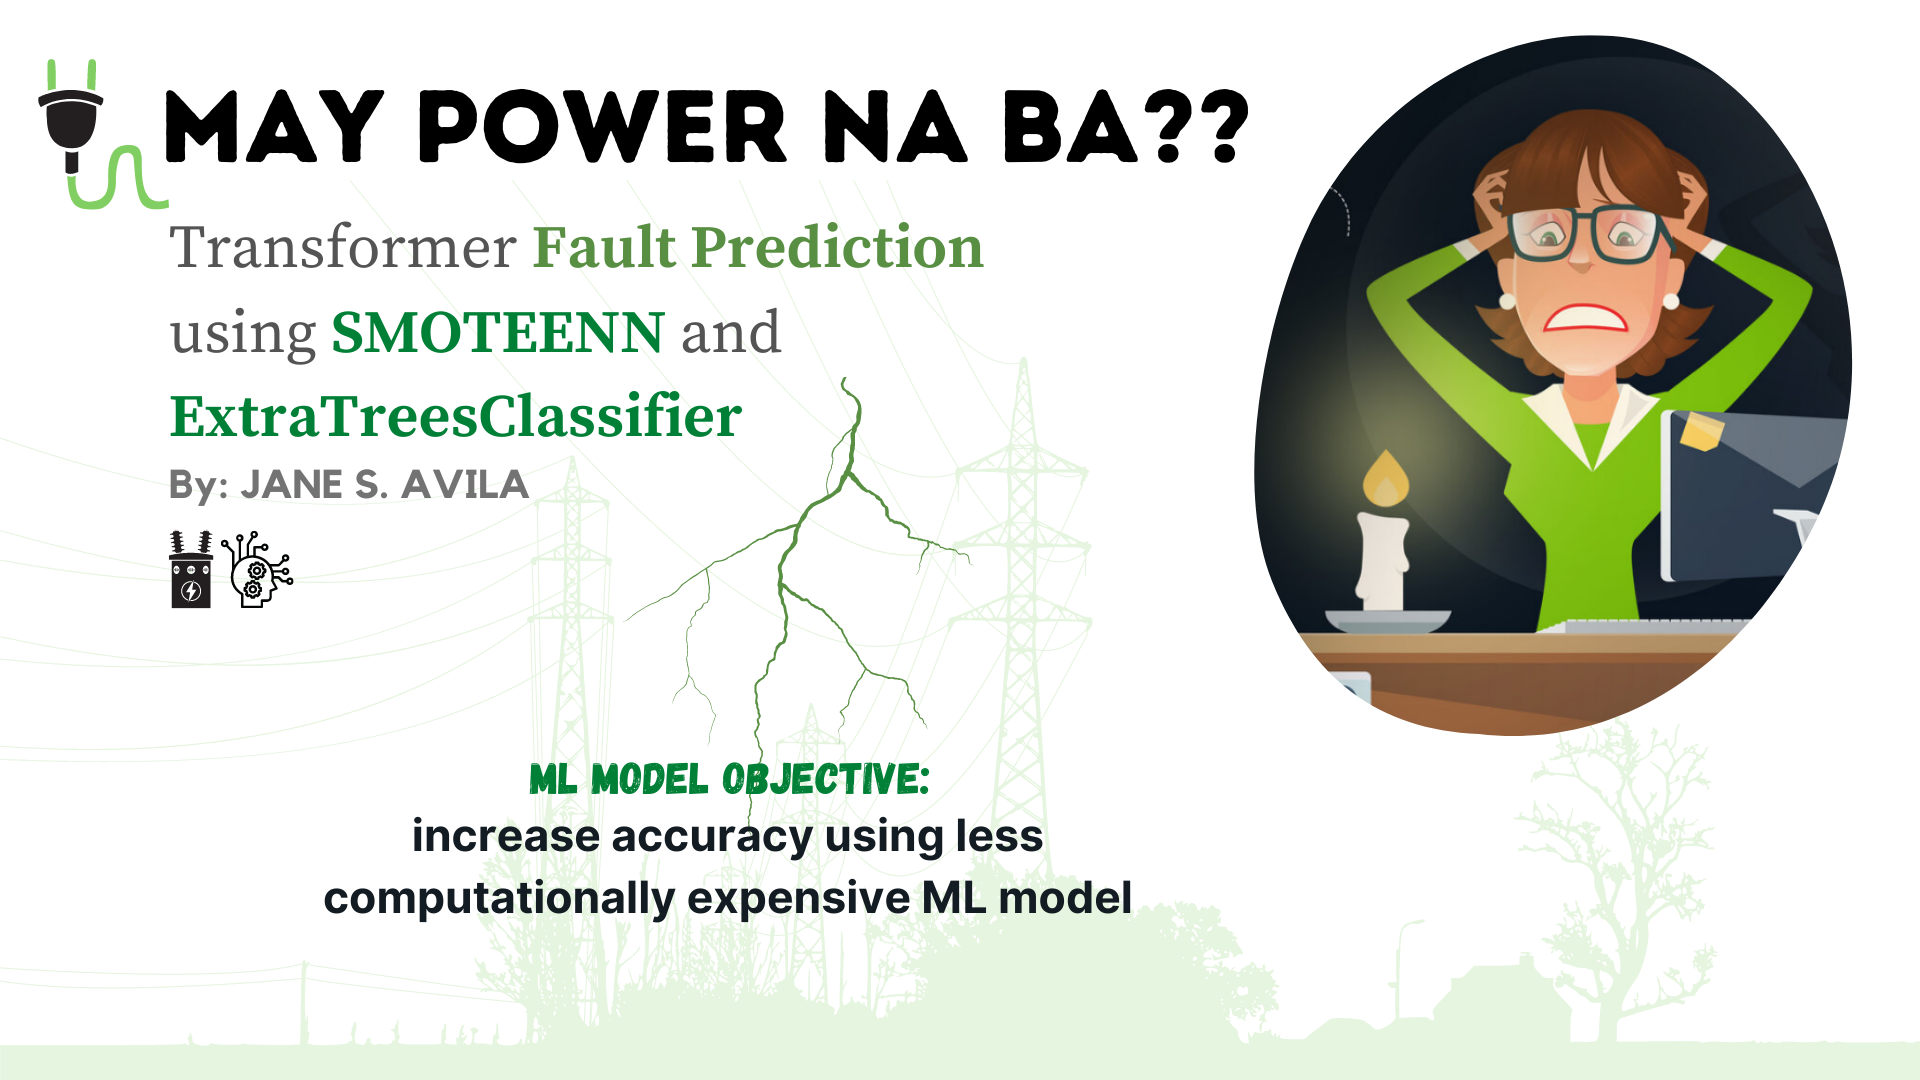

In [193]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import datetime

from collections import Counter
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [194]:
def load_merge_datasets():
    """
    Return merged datasets.
    """
    df_overview = pd.read_csv('Overview.csv')
    df_overview['DeviceTimeStamp'] = pd.to_datetime(df_overview
                                                    ['DeviceTimeStamp'],
                                                    format =
                                                    '%Y-%m-%d %H:%M:%S')
    df_currvolt = pd.read_csv('CurrentVoltage.csv')
    df_currvolt['DeviceTimeStamp'] = pd.to_datetime(df_currvolt
                                                    ['DeviceTimeStamp'],
                                                    format =
                                                    '%Y-%m-%d %H:%M:%S')
    df = pd.merge(df_overview, df_currvolt, on='DeviceTimeStamp')
    return df

def plot_heatmap_corr(transformer):
    """
    Returns the correlation heatmap of the dataset.
    """
    sns.set(rc={'figure.figsize':(12, 10)})
    df_transformer = transformer.copy()
    mask = np.triu(np.ones_like(df_transformer.corr(),
                                dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    (sns.heatmap(data=df_transformer.corr(), annot=True,
                 fmt='.2f', mask=mask, cmap=cmap)
     .set_title('Figure 1: Correlation Heatmap of Dataset'))
    return plt.show()

def plot_target():
    """
    Plots the level of the target variable versus datetime.
    """
    sns.set(rc={'figure.figsize':(16, 6), 'axes.facecolor':'white',
            'figure.facecolor':'white'})
    (sns.lineplot(data=transformer, x='DeviceTimeStamp', y='MOG_A')
     .set_title(
         'Figure 2: Plot of Target Value Per Data Collection Timestamp'
     ))
    return plt.show()

def plot_datapoints_count():
    """
    Plots the value counts of the target variable.
    """
    sns.set(rc={'figure.figsize':(6, 4), 'axes.facecolor':'white',
            'figure.facecolor':'white'})
    df_target_count = (transformer['MOG_A']
                       .value_counts()
                       .reset_index()
                       .rename(columns={'index': 'MOG_A', 'MOG_A': 'Count'}))
    ax = sns.barplot(data=df_target_count, x='MOG_A', y='Count')
    ax.set_title('Figure 3: Count of Data Points per Class')
    ax.bar_label(ax.containers[0])
    return plt.show()

def generate_xy(df):
    """
    Return x (features) and y (target) variables of the dataset.
    """
    df_trans = df.copy()
    x = df_trans.drop(['DeviceTimeStamp', 'MOG_A'], axis=1)
    y = df_trans['MOG_A']
    return x, y

def run_eval(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=.20,
                                                        random_state=50000)
    dfs = []
    models = [
      ('RF', RandomForestClassifier()),
      ('GBM', GradientBoostingClassifier()),
      ('ET', ExtraTreesClassifier()), 
      ('ADA', AdaBoostClassifier())
    ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted',
               'recall_weighted', 'f1_weighted',
               'roc_auc']
    target_names = ['Fault', 'No Fault']
    classification_report_df = []
    classification_report_list = []

    y_pred_df = []
    y_pred_list = []
    accuracy = []
    error = []

    for name, model in models:
        kfold = model_selection.KFold(n_splits=5,
                                      shuffle=True,
                                      random_state=500000)
        cv_results = model_selection.cross_validate(model,
                                                    X_train,
                                                    y_train,
                                                    cv=kfold,
                                                    scoring=scoring)
        clf = model.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_pred_list.append(y_pred)
        this_y_pred_df = pd.DataFrame(y_pred)
        this_y_pred_df["model"] = name
        y_pred_df.append(this_y_pred_df) 
        results.append(cv_results)
        names.append(name)
        accuracy.append((model.score(X_test,y_test)))
        error.append(mean_squared_error(y_test,y_pred))
        classification_report_result = (classification_report
                                        (y_test,
                                         y_pred,
                                         target_names=target_names,
                                         output_dict=True)
                                       )
        classification_report_list.append(classification_report_result)
        this_classification_report_df = (pd.DataFrame(
                                         classification_report_result)
                                         .transpose())
        this_classification_report_df["model"] = name
        classification_report_df.append(this_classification_report_df)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)

    binary_classification_report_df_final = pd.concat(
        classification_report_df,
        ignore_index=True
    )
    y_pred_df_final = pd.concat(y_pred_df, ignore_index=True)
    y_pred_df_final.rename(columns = {
        0 : "y_pred"
    }, inplace = True )

    mods = []
    for model in list(set(final.model.values)):
        model_df = final.loc[final.model == model]
        mods.append(model_df)

    binary_mods_df = pd.concat(mods, ignore_index=True)
    binary_results_long = pd.melt(binary_mods_df,id_vars=['model'],
                                  var_name='metrics', value_name='values')
    time_metrics = ['fit_time','score_time']
    binary_results_long_nofit = (binary_results_long
                                 .loc[~binary_results_long['metrics']
                                      .isin(time_metrics)]) 
    binary_results_long_nofit = (binary_results_long_nofit
                                 .sort_values(by='values'))
    binary_results_long_fit = (binary_results_long
                               .loc[binary_results_long['metrics']
                                    .isin(time_metrics)])
    binary_results_long_fit = (binary_results_long_fit
                               .sort_values(by='values'))
    metrics = list(set(binary_results_long_nofit.metrics.values))
    df_metrics = (binary_mods_df
                  .groupby(['model'])[metrics]
                  .agg([np.std, np.mean]))

    time_metrics = list(set(binary_results_long_fit.metrics.values))
    df_time_metrics = (binary_mods_df
                       .groupby(['model'])[time_metrics]
                       .agg([np.std, np.mean]))
    return binary_results_long_nofit, df_metrics, df_time_metrics

def plot_performance(binary_results_long_nofit):
    sns.set(rc={'figure.figsize':(8, 8),
                'axes.facecolor':'white',
                'figure.facecolor':'white'})
    return sns.boxenplot(data=binary_results_long_nofit, x="model",
                  y="values", hue='metrics', palette='BuGn_r')

# Introduction


Transformer plays a very important role in the electric power distribution system. Though these are some of the most reliable component of the electrical grid, transformers are also prone to failure due to many factors both internal or external. Transformers are the most crucial part of electrical distribution power system and its failure may result in not only interrupted power supply but also great economic loss. So, it is important to monitor transformer health on daily bases. Many diagnostic techniques are available for this purpose. Typically, in an electrical distribution system, a thousand of transformers at various locations in the network are employed. Analyzing if the fault is in a single transformer is cumbersome since transformer health is normally unpredictable. In this study, the use of machine learning model to predict if a transformer is faulty or not is explored. 

For more information regarding the transformer used in here, you may refer to the dataset source at this link: https://www.kaggle.com/code/pythonafroz/transformer-fault-prediction-with-99-auc.


# Problem Statement

For a transformer fault prediction model, what is the least computationally expensive model with the best performance scores that we can design using ensembles of decision trees?

# Data Preparation and Pre-processing

## Loading and Merging of Datasets

Two dataset files are merged based on the recorded data collection time. One is Overview.csv which contains the status of the transformer indicator parameters per data collection time and the other is CurrentVoltage.csv which contains the measured voltages and currents in the windings of the transformer per data collection time. Table 1 contains the summary and a brief description of each features of the dataset.

<center><b> Table 1: Dataset Feature Description and Types</b></center> 

| Features of Raw Data | Description | Converted Data Type | Status |
|:--------|:----------|:----------|:--------|
|OTI | Oil Temperature Indicator | float64 | Retained |
|ATI | Ambient Temperature Indicator | float64 | Retained |
|WTI | Winding Temperature Indicator | float64 | Retained |
|OLI | Oil Level Indicator | float64 | Dropped |
|OTI_A | Oil Temperature Indicator Alarm | float64 | Retained |
|OTI_T | Oil Temperature Indicator Trip | float64 | Retained |
|MOG_A | Magnetic oil gauge indicator | float64 | Target |
|DeviceTimeStamp | datetime64[ns] | float64 | Dropped |
|VL1 | Phase Line 1 | float64 | Retained |
|VL2 | Phase Line 2 |float64 | Retained |
|VL3 | Phase Line 3 | float64 | Retained |
|IL1 | Current Line 1 | float64 | Retained |
|IL2 | Current Line 2 | float64 | Retained |
|IL3 | Current Line 3 | float64 | Retained |
|VL12 | Voltage line 1 2 | float64 | Retained |
|VL23 | Voltage line 2 3 | float64 | Dropped |
|VL31 | Voltage line 3 1 | float64 | Dropped |
|INUT | Neutral Current | float64 | Dropped |

The features of the data are parameters of the transformer that were collected by IoT devices. Using these parameters, the a model is built in this study to predict whether a transformer is faulty or not.

## Merged Datasets (Head)

In [195]:
transformer = load_merge_datasets()
transformer.head()

,DeviceTimeStamp,OTI,WTI,ATI,OLI,OTI_A,OTI_T,MOG_A,VL1,VL2,VL3,IL1,IL2,IL3,VL12,VL23,VL31,INUT
0,2019-06-25 13:06:00,0.0,0.0,0.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-06-27 10:49:00,0.0,0.0,0.0,38.0,0.0,0.0,0.0,238.7,238.7,238.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-06-27 10:51:00,0.0,0.0,0.0,38.0,0.0,0.0,0.0,238.4,238.5,238.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-06-27 10:52:00,0.0,0.0,0.0,39.0,0.0,0.0,0.0,239.9,240.0,240.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-06-27 10:52:00,0.0,0.0,0.0,39.0,0.0,0.0,0.0,239.9,240.0,240.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Shape of Dataset

In [196]:
transformer.shape

(20465, 18)

The raw data contains about 20,465 data points, 17 features, and 1 target.

## Descriptive Statistics of Dataset

The high standard deviation of data may be observed here.

In [197]:
transformer.describe()

,OTI,WTI,ATI,OLI,OTI_A,OTI_T,MOG_A,VL1,VL2,VL3,IL1,IL2,IL3,VL12,VL23,VL31,INUT
count,20465.000000,20465.000000,20465.000000,20465.000000,20465.000000,20465.000000,20465.000000,20465.000000,20465.000000,20465.000000,20465.000000,20465.000000,20465.000000,20465.000000,20465.000000,20465.000000,20465.000000
mean,30.084974,0.259614,27.770291,69.685561,0.003616,0.001613,0.100024,241.054298,240.518471,239.948307,70.640137,56.540704,79.806504,364.269900,363.370222,364.753975,25.231747
std,10.710617,0.438434,5.742023,27.778116,0.060025,0.040125,0.300040,9.243036,9.645709,8.551468,42.819608,41.185621,45.669723,139.137449,138.572355,139.285162,15.674539
min,0.000000,0.000000,0.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,0.000000,24.000000,40.000000,0.000000,0.000000,0.000000,235.800000,235.500000,235.500000,43.700000,28.800000,53.200000,397.700000,398.500000,399.300000,15.400000
50%,30.000000,0.000000,28.000000,64.000000,0.000000,0.000000,0.000000,242.400000,241.900000,241.000000,67.500000,48.700000,77.700000,416.300000,415.400000,416.600000,24.800000
75%,34.000000,1.000000,32.000000,100.000000,0.000000,0.000000,0.000000,247.300000,246.500000,245.100000,98.300000,80.200000,111.800000,427.200000,425.000000,427.300000,35.200000
max,248.000000,1.000000,44.000000,100.000000,1.000000,1.000000,1.000000,261.200000,261.300000,261.300000,224.100000,253.600000,247.300000,446.500000,444.800000,447.300000,145.800000


# Exploratory Data Analysis

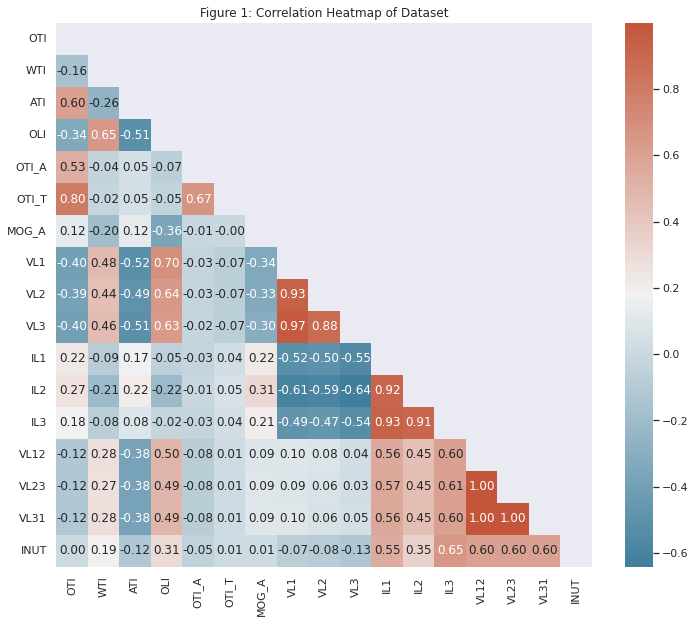

In [198]:
plot_heatmap_corr(transformer)

Correlation heatmap shows us that there are features that are highly correlated. Phase Line Voltage, Current, and Line-to-line voltages are the ones that are highly correlated. This can normally be observed since these parameters are measured in the windings of the transformer. To avoid bias in the model, some features that are highly correlated are dropped.

In [199]:
df = transformer.drop(['OLI', 'VL12', 'VL23'], axis=1)
df.shape

(20465, 15)

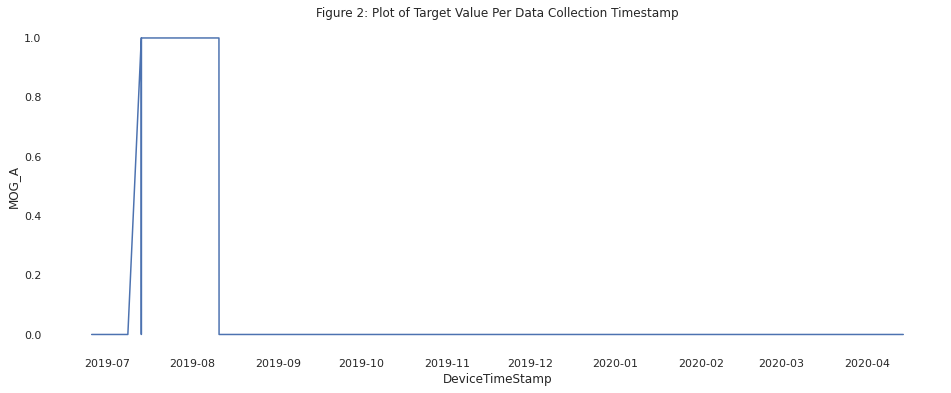

In [200]:
plot_target()

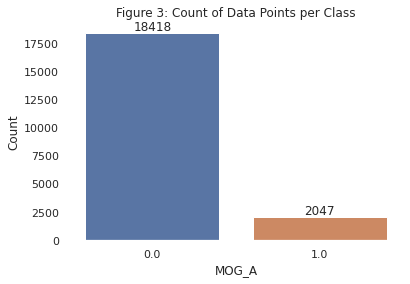

In [201]:
plot_datapoints_count()

Upon performing EDA, one characteristic of the data seems apparent. Figures 2 and 3 show that the dataset is highly imbalance. Only ~10% out of the 20,000 data points were predicted as indicator of fault. This is what we call an imbalance classification. Imbalance classification results to poor predictive performance specifically to the minority class. This means that in selecting a machine learning model for the intended objective, the tendency of having higher class imbalance must be considered especially in this type of application when one class is typically much less than the other.

To solve this, resampling method may be used. A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and/or adding more examples from the minority class (over-sampling).

In this study, a type of over-sampling, under-sampling, and a combination of both are arbitrarily chosen. Each type of technique will be performed before applying the raw data to the machine learning model. The performance of the model using the different resampling techniques will be evaluated to determine which type of resampling technique is best suited for this type of application.

# Dealing with Imbalanced Classification using Resampling

There are a number of different techniques that we can use to perform resampling. In this study, all of the types use are arbitrarily chosen from the imbalance learning module of python. These are NearMiss, SMOTE, and SMOTEENN. Let us first assign variables x for the features and y for the target.

In [202]:
x, y = generate_xy(df)

## NearMiss

NearMiss is an under-sampling technique. It aims to balance class distribution by randomly eliminating majority class examples. When instances of two different classes are very close to each other, the instances of the majority class are removed to increase the spaces between the two classes. This helps in the classification process.

In [203]:
from imblearn.under_sampling import NearMiss

nm = NearMiss()
x_nm, y_nm = nm.fit_resample(x, y)

print('Original dataset shape:', Counter(y))
print('Resample dataset shape:', Counter(y_nm))

Original dataset shape: Counter({0.0: 18418, 1.0: 2047})
Resample dataset shape: Counter({0.0: 2047, 1.0: 2047})


In [204]:
df_trans_res_nm = x_nm.copy()
df_trans_res_nm['MOG_A'] = y_nm

## SMOTE

SMOTE (synthetic minority oversampling technique) is one of the most commonly used oversampling methods to solve the imbalance problem. It aims to balance class distribution by randomly increasing minority class examples by replicating them. SMOTE synthesises new minority instances between existing minority instances. It generates the virtual training records by linear interpolation for the minority class. These synthetic training records are generated by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. After the oversampling process, the data is reconstructed and several classification models can be applied for the processed data.

In [205]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0.0: 18418, 1.0: 2047})
Resample dataset shape Counter({0.0: 18418, 1.0: 18418})


In [206]:
df_trans_res_smote = x_smote.copy()
df_trans_res_smote['MOG_A'] = y_smote

## SMOTEENN

SMOTE with Edited Nearest Neighbor (ENN) is a method that combines the SMOTE ability to generate synthetic examples for minority class and ENN ability to delete some observations from both classes that are identified as having different class between the observation’s class and its K-nearest neighbor majority class.

In [207]:
from imblearn.combine import SMOTEENN

smt = SMOTEENN()
x_smoteenn, y_smoteenn = smt.fit_resample(x, y)

print('Original dataset shape:', Counter(y))
print('Resample dataset shape:', Counter(y_smoteenn))

Original dataset shape: Counter({0.0: 18418, 1.0: 2047})
Resample dataset shape: Counter({1.0: 18214, 0.0: 15726})


In [208]:
df_trans_res_smotenn = x_smoteenn.copy()
df_trans_res_smotenn['MOG_A'] = y_smoteenn

# Machine Learning Model Selection, Validation, and Test

The best types of machine learning model to use for imbalanced classification include the ensembles of decision trees. Specifically, RandomForest Classifiers (RF) are the best type of model to use for imbalance classification.

A variation of RF, the ExtraTrees Classifier, is also used in this study and the performance of the two models are then evaluated. ExtraTrees has the inherent advantage of faster execution time than RF. Thus, an assessment of this type of model is performed since this can pose some advantages for the application of this study.

Gradient-boosting based ensembles are also used and evaluated and the performance of the ensembles are compared. All models are used in their default settings to provide a baseline comparison.

To evaluate the performance of the model, KFold cross-validation with n_splits = 5 is used. KFold is a type of validation technique that is best-suited for imbalance classification. The test accuracy, performance scores such as F1, precision, recall and AUROC are computed for each resampling technique and ML model combination.

The following is a description of each type of performance metrics used:

`Accuracy:`
Accuracy is the proportion of true results among the total number of cases examined. Accuracy is a valid choice of evaluation for classification problems which are well balanced and not skewed or No class imbalance.

`Precision:`
Precision is a valid choice of evaluation metric when we want to be very sure of our prediction.

`Recall:`
Recall is a valid choice of evaluation metric when we want to capture as many positives as possible.

`F1 score:`
The F1 score is a number between 0 and 1 and is the harmonic mean of precision and recall. F1 score maintains a balance between the precision and recall for classifier. If your precision is low, the F1 is low and if the recall is low again your F1 score is low.

`AUC ROC:`
AUC ROC indicates how well the probabilities from the positive classes are separated from the negative classes.

# Results

## No Resampling

Text(0.5, 1.0, 'Figure 4: Performance Metrics of ML Models when No Resampling is Applied')

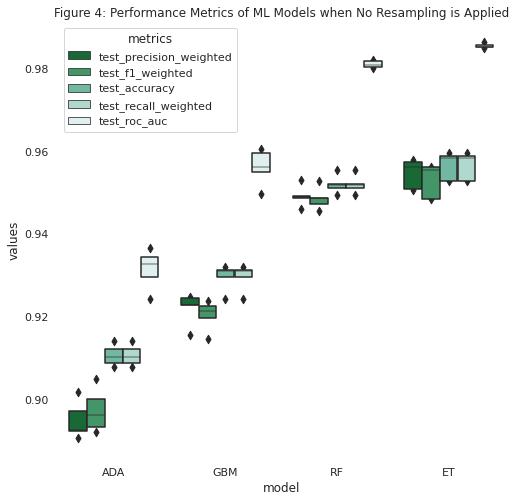

In [209]:
X = x
y_ = y
binary_results_long_nofit, df_metrics, df_time_metrics = run_eval(X, y_)
plot_performance(binary_results_long_nofit).set_title(
     'Figure 4: Performance Metrics of ML Models when No Resampling is' 
      ' Applied'
     )

In [210]:
df_metrics

test_f1_weighted           test_recall_weighted           test_accuracy  \
                   std      mean                  std      mean           std   
model                                                                           
ADA           0.005305  0.897289             0.002583  0.910579      0.002583   
ET            0.004153  0.952917             0.003371  0.956328      0.003371   
GBM           0.003576  0.920368             0.003107  0.929575      0.003107   
RF            0.002722  0.948519             0.002223  0.951930      0.002223   

                test_roc_auc           test_precision_weighted            
           mean          std      mean                     std      mean  
model                                                                     
ADA    0.910579     0.004819  0.931446                0.004512  0.894982  
ET     0.956328     0.000596  0.985330                0.003527  0.954511  
GBM    0.929575     0.004296  0.956110                0.003709  0.922034  
RF     0.951930     0.000797  0.980892                0.002493  0.949164

Mean of performance scores of the best model, that is ET, is around 95% with no resampling.

In [211]:
df_time_metrics

fit_time           score_time          
            std      mean        std      mean
model                                         
ADA    0.025968  0.612488   0.006779  0.083668
ET     0.014498  0.627144   0.014588  0.175924
GBM    0.073733  2.408655   0.001848  0.025318
RF     0.034185  1.190205   0.007349  0.148053

## NearMiss

Text(0.5, 1.0, 'Figure 5: Performance Metrics of ML Models when NearMiss is Applied')

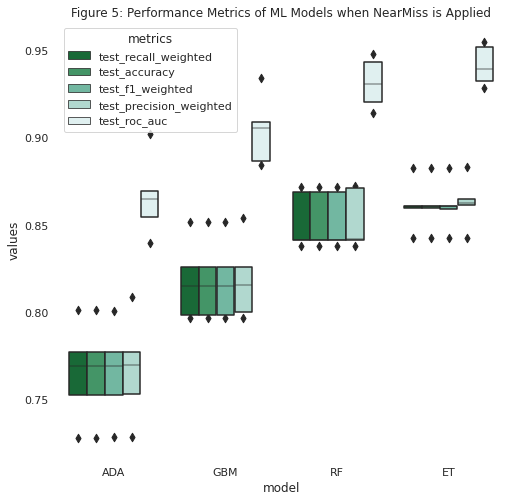

In [212]:
X = x_nm
y_ = y_nm
binary_results_long_nofit, df_metrics, df_time_metrics = run_eval(X, y_)
plot_performance(binary_results_long_nofit).set_title(
     f'Figure 5: Performance Metrics of ML Models when NearMiss is' 
      ' Applied'
     )


In [213]:
df_metrics

test_recall_weighted           test_f1_weighted           test_accuracy  \
                       std      mean              std      mean           std   
model                                                                           
ADA               0.027387  0.765802         0.027139  0.765660      0.027387   
ET                0.014092  0.861374         0.014099  0.861307      0.014092   
GBM               0.022609  0.817710         0.022567  0.817660      0.022609   
RF                0.016528  0.852214         0.016504  0.852189      0.016528   

                test_roc_auc           test_precision_weighted            
           mean          std      mean                     std      mean  
model                                                                     
ADA    0.765802     0.023073  0.866048                0.029776  0.767458  
ET     0.861374     0.011562  0.941368                0.014250  0.862868  
GBM    0.817710     0.020267  0.903875                0.023137  0.818587  
RF     0.852214     0.014439  0.931310                0.017184  0.853038

Mean of performance scores of the best model, that is ET, is around 86% with NearMiss resampling.

In [214]:
df_time_metrics

fit_time           score_time          
            std      mean        std      mean
model                                         
ADA    0.009753  0.196885   0.002733  0.039748
ET     0.018481  0.272560   0.006935  0.083977
GBM    0.027648  0.586472   0.001023  0.011484
RF     0.025231  0.439652   0.003863  0.071911

## SMOTE

Text(0.5, 1.0, 'Figure 6: Performance Metrics of ML Models when SMOTE is Applied')

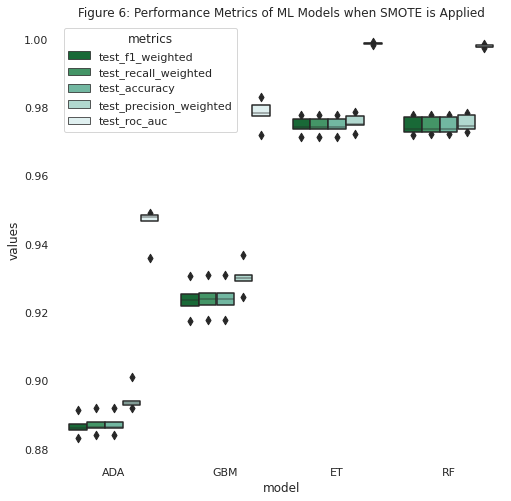

In [215]:
X = x_smote
y_ = y_smote
binary_results_long_nofit, df_metrics, df_time_metrics = run_eval(X, y_)
plot_performance(binary_results_long_nofit).set_title(
     f'Figure 6: Performance Metrics of ML Models when SMOTE is' 
      ' Applied'
     )

In [216]:
df_metrics

test_recall_weighted           test_f1_weighted           test_accuracy  \
                       std      mean              std      mean           std   
model                                                                           
ADA               0.002985  0.887200         0.002948  0.886668      0.002985   
ET                0.002599  0.974650         0.002601  0.974638      0.002599   
GBM               0.004841  0.924053         0.004853  0.923778      0.004841   
RF                0.002624  0.974650         0.002625  0.974641      0.002624   

                test_roc_auc           test_precision_weighted            
           mean          std      mean                     std      mean  
model                                                                     
ADA    0.887200     0.005472  0.945545                0.003594  0.894591  
ET     0.974650     0.000287  0.998700                0.002438  0.975597  
GBM    0.924053     0.004114  0.978183                0.004468  0.930257  
RF     0.974650     0.000474  0.997808                0.002463  0.975362

Mean of performance scores of the best model, that is ET, is around 97% with SMOTE resampling.

In [217]:
df_time_metrics

fit_time           score_time          
            std      mean        std      mean
model                                         
ADA    0.016685  1.487354   0.003890  0.126932
ET     0.020860  1.337128   0.012411  0.329891
GBM    0.040417  6.230846   0.002748  0.043000
RF     0.129985  4.832505   0.007785  0.279516

## SMOTEENN

Text(0.5, 1.0, 'Figure 7: Performance Metrics of ML Models when SMOTEENN is Applied')

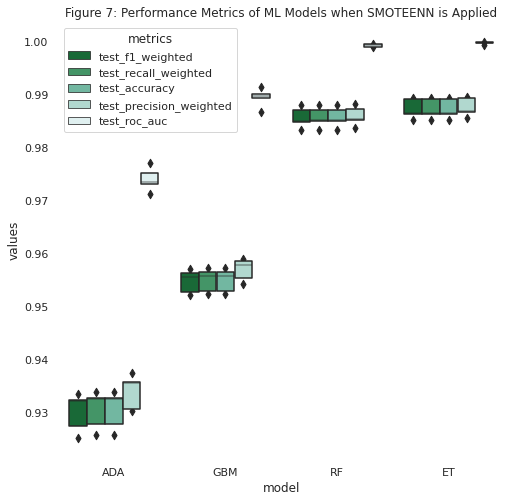

In [218]:
X = x_smoteenn
y_ = y_smoteenn
binary_results_long_nofit, df_metrics, df_time_metrics = run_eval(X, y_)
plot_performance(binary_results_long_nofit).set_title(
     f'Figure 7: Performance Metrics of ML Models when SMOTEENN is' 
      ' Applied'
     )

In [219]:
df_metrics

test_recall_weighted           test_f1_weighted           test_accuracy  \
                       std      mean              std      mean           std   
model                                                                           
ADA               0.003555  0.930576         0.003584  0.930173      0.003555   
ET                0.001802  0.987331         0.001805  0.987317      0.001802   
GBM               0.002241  0.954957         0.002241  0.954779      0.002241   
RF                0.001903  0.985673         0.001907  0.985657      0.001903   

                test_roc_auc           test_precision_weighted            
           mean          std      mean                     std      mean  
model                                                                     
ADA    0.930576     0.002189  0.974045                0.003234  0.933959  
ET     0.987331     0.000179  0.999686                0.001719  0.987587  
GBM    0.954957     0.001748  0.989453                0.002078  0.957038  
RF     0.985673     0.000272  0.999237                0.001807  0.985959

Mean of performance scores of the best model, that is ET, is around 98.7% with SMOTEENN resampling.

In [220]:
df_time_metrics

fit_time           score_time          
            std      mean        std      mean
model                                         
ADA    0.032642  1.404382   0.010457  0.118946
ET     0.030897  1.062265   0.010533  0.285685
GBM    0.039581  5.744738   0.002442  0.038012
RF     0.050717  4.427651   0.010063  0.238071

## Summary of Insights

- Results showed that test accuracy and performance scores are higher in a model that uses resampling than a model which did not use resampling. 

- Results showed that for the dataset described here the SMOTEENN provides the best test accuracy and performance scores among the three types of resampling techniques used. On the other hand, model that uses NearMiss or under-sampling is the worst performing model. This means that for the model that will be used in this dataset, being able to see wider variance of the data is needed for the model to perform better.

- Meanwhile, for the ensemble of decision trees used, results showed that the best classifier is the ExtraTrees Classifier followed by Random Forest. The resampling techniques used by these models in their algorithm is what made them perform better for imbalanced classification than those gradient-boosting based ensembles. This is because the latter uses weak trees in their resampling algorithm.

- Aside from the fact that ExtraTrees Classifier has slightly better test accuracy and performance score than RF, it is also important to take note that the execution time (mean fit time plus score time) for ExtraTrees is lower by 70% than that of RF.

# Conclusions

Using the available dataset, it was found out that an ExtraTrees Classification Model which uses SMOTEENN resampling method can provide the best performance for transformer fault prediction.

# Recommendations

- Future researchers may conduct analysis on top predictors of the model to determine which parameters are most significant in predicting faults in transformers.
- Future researchers may also conduct study on the design of a machine learning model that can predict when a transformer will be faulty. This model can provide opportunities for further studies on predictive maintenance of transformers or other equipment used in electrical distribution systems.

# References

- https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/#:~:text=Oversampling%20methods%20duplicate%20or%20create,of%20methods%20are%20used%20together

- https://www.kaggle.com/code/elakapoor/predictive-electrical-fault-analysis

- https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

- https://towardsdatascience.com/an-intuitive-explanation-of-random-forest-and-extra-trees-classifiers-8507ac21d54b

- https://towardsdatascience.com/what-when-how-extratrees-classifier-c939f905851c

- https://www.kaggle.com/code/pythonafroz/transformer-fault-prediction-with-99-auc

- https://quantdare.com/what-is-the-difference-between-extra-trees-and-random-forest/